In [2]:
import sys
sys.path.append('..')
from nbhd.data import Base

Initializing database connection...
Database connected!


In [3]:
db = Base()

In [4]:
db.ls()

['spatial_ref_sys',
 'slimroads',
 'pixels',
 'britain',
 'tiles',
 'opennames',
 'openroads',
 'openmaplocal',
 'openuprn',
 'railways',
 'rivers',
 'coastline',
 'roadnodes']

In [5]:
britain = db.select('britain')

In [6]:
b = britain.geometry[0]

In [7]:
tiles = db.intersects('tiles', b)

<AxesSubplot:>

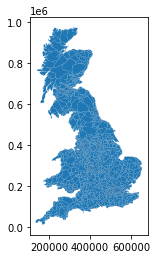

In [8]:
tiles.plot()

In [9]:
pixels = db.intersects('pixels', b)

<AxesSubplot:>

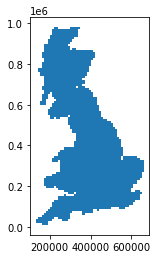

In [10]:
pixels.plot()

In [11]:
len(pixels)

2512

In [12]:
len(tiles)

30034

In [13]:
from shapely.geometry import Point

In [21]:
p = Point(400001,300001)

In [22]:
pixel = db.intersects('pixels', p)

In [23]:
pixel

,geometry
0,"POLYGON ((400000.000 300000.000, 400000.000 31..."


In [24]:
import matplotlib.pyplot as plt

<AxesSubplot:>

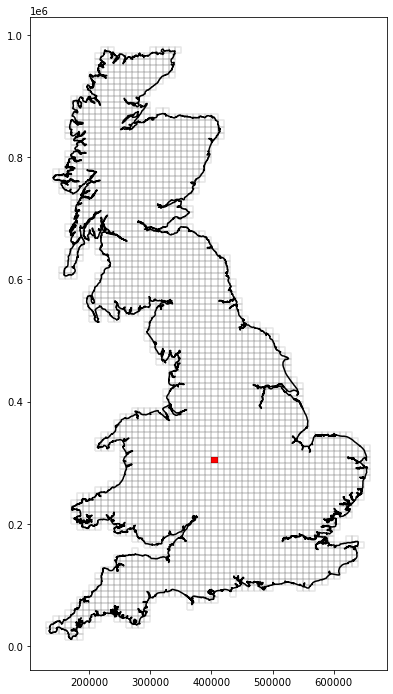

In [25]:
f, ax = plt.subplots(figsize=(12,12))
britain.boundary.plot(ax=ax, color='k')
pixels.boundary.plot(ax=ax, color='k', alpha=0.1)
pixel.plot(ax=ax, color='red')

In [26]:
# augmented pixel is pixel plus intersecting tiles

In [27]:
pixel_tiles = db.intersects('tiles', pixel.geometry[0])

<AxesSubplot:>

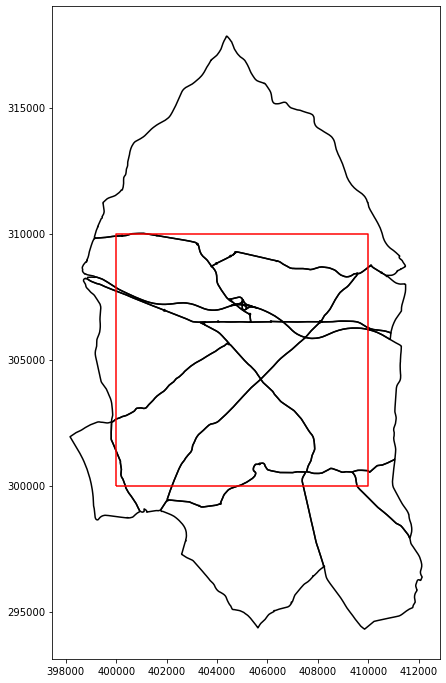

In [31]:
f, ax = plt.subplots(figsize=(12,12))
pixel_tiles.boundary.plot(ax=ax, color='k')
pixel.boundary.plot(ax=ax, color='red')

In [35]:
from shapely.geometry import MultiPolygon

In [40]:
expanded_pixel = MultiPolygon(pixel_tiles.geometry.values)

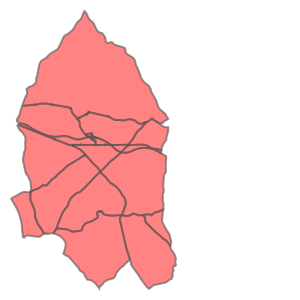

In [41]:
expanded_pixel

In [45]:
def get_communities(geometry, 
                    db,
                footprint_threshold=250, 
                res_length_threshold=50, 
                short_threshold=50, 
                min_community_size=4, 
                node_distance=20):

    # nearest roads ~ 'slimroads' is without motorways and secondary roads
    nr_roads = db.nearest_neighbours('slimroads', geometry)
    # nearest buildings
    nr_buildings = db.nearest_neighbours('openmaplocal', geometry)
    # merge on UPRN
    df = nr_buildings.merge(nr_roads, on=['UPRN', 'uprn_geometry'], 
                            how='inner', suffixes=('_building', '_street'))

    # 1 eliminate non-building properties : distance to building must == 0
    df1 = df.loc[df.dist_building==0].copy()

    # 2 eliminate non-residential buildings
    building_counts = dict(df1.id_building.value_counts())
    df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))
    df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
    df1['footprint_area_per_uprn'] = df1.footprint_area / df1.building_counts
    df1['residential_building'] = df1['footprint_area_per_uprn'] < footprint_threshold
    df2 = df1.loc[df1.residential_building].copy()

    # 3 establish whether roads are residential 
    street_counts = dict(df2.id_street.value_counts())
    df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))
    df2['street_length_per_uprn'] = df2.length / df2.street_counts
    df2['residential_street'] = df2.street_length_per_uprn < res_length_threshold
    residential = dict(zip(df2.id_street, df2.residential_street))
    df['residential'] = df.id_street.apply(lambda x: residential.get(x, False))
    df['short_street'] = df.length < short_threshold
    df['res_or_short'] = df.residential | df.short_street
    df3 = df.loc[df.res_or_short].copy()

    # 4 treat nearby nodes as equivalent
    translator = db.get_nearest_nodes_translator(self.geom, node_distance)
    edges = df3.loc[~df3.duplicated()].copy()
    edges['translated_start'] = edges.startNode.apply(lambda x: translator.get(x, x))
    edges['translated_end'] = edges.endNode.apply(lambda x: translator.get(x, x))

    # 5 find connected networks of residential streets
    g = nx.from_pandas_edgelist(edges, 'translated_start', 'translated_end', True)
    subgraphs =[g.subgraph(c) for c in nx.connected_components(g)]
    sgs = [sg for sg in subgraphs if len(sg) >= min_community_size]

    # 6 add community labels
    communities = dict()
    for i in range(len(sgs)):
        communities[str(i+1).zfill(2)] = list(nx.get_edge_attributes(sgs[i], 'id_street').values())
    communities_key = {value:key for key, value_list 
                       in communities.items() for value in value_list}

    df['community'] = df.id_street.apply(lambda x: communities_key.get(x, None))
    return df


In [47]:
df = get_communities(expanded_pixel, db)

AttributeError: 'Base' object has no attribute '_contains_query'

In [49]:
tiles

,geometry
0,"POLYGON ((633409.010 160909.300, 633389.000 16..."
1,"POLYGON ((255264.084 372099.537, 255210.000 37..."
2,"POLYGON ((348203.000 470627.000, 348099.000 47..."
3,"POLYGON ((345140.543 479211.552, 345168.000 47..."
4,"POLYGON ((331967.935 478680.000, 332020.000 47..."
...,...
30029,"POLYGON ((511157.920 195894.010, 511200.650 19..."
30030,"POLYGON ((516525.800 187977.700, 516663.780 18..."
30031,"POLYGON ((508984.130 189244.220, 508966.770 18..."
30032,"POLYGON ((510149.790 185910.790, 510439.430 18..."


In [50]:
pixels

,geometry
0,"POLYGON ((130000.000 20000.000, 130000.000 300..."
1,"POLYGON ((130000.000 30000.000, 130000.000 400..."
2,"POLYGON ((140000.000 20000.000, 140000.000 300..."
3,"POLYGON ((140000.000 30000.000, 140000.000 400..."
4,"POLYGON ((140000.000 40000.000, 140000.000 500..."
...,...
2507,"POLYGON ((650000.000 280000.000, 650000.000 29..."
2508,"POLYGON ((650000.000 290000.000, 650000.000 30..."
2509,"POLYGON ((650000.000 300000.000, 650000.000 31..."
2510,"POLYGON ((650000.000 310000.000, 650000.000 32..."
